In [1]:
import cv2
import numpy as np
import pywt
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import math

In [2]:
# Utility Functions...

def rgb_to_yiq(rgb_image):
    transformation_matrix = np.array([[0.299, 0.587, 0.114],
                                      [0.596, -0.275, -0.321],
                                      [0.212, -0.523, 0.311]])
    yiq_image = np.dot(rgb_image, transformation_matrix)
    return yiq_image

def yiq_to_rgb(yiq_image):
    transformation_matrix = np.array([[1.000, 0.956, 0.620],
                                      [1.000, -0.272, -0.647],
                                      [1.000, -1.108, 1.703]])
    rgb_image = np.dot(yiq_image, np.linalg.inv(transformation_matrix))
    return rgb_image

def normalize_2dshape(A, matrix):
    rows_diff = A.shape[0] - A.shape[0]
    cols_diff = matrix.shape[1] - matrix.shape[1]

    A = np.pad(matrix, ((rows_diff, 0), (cols_diff, 0)), mode='constant')
    return A

def normalize_3dshape(A, matrix):
    rows_diff = A.shape[0] - A.shape[0]
    cols_diff = matrix.shape[1] - matrix.shape[1]

    A = np.pad(matrix, ((rows_diff, 0), (cols_diff, 0), (0, 0)), mode='constant')
    return A

def normalized_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    
    c = np.correlate(a, b, 'full')
    c = np.linalg.norm(c)
    
    return c.item()

def show_image_1(image, label):
      fig, axs = plt.subplots(1, 1, figsize=(4, 4))
      plt.subplots_adjust(wspace=0, hspace=0)

      axs.imshow(image, cmap='gray')
      axs.axis('off')
      axs.set_title(label)
      
      plt.show()

def show_image(images, labels, axes):
    fig, axs = plt.subplots(axes[0], axes[1], figsize=(6, 6))
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
      
    if(sum(axes) == 2):
        axs.imshow(images[0], cmap='gray')
        axs.axis('off')
        axs.set_title(labels[0])
        
    elif(sum(axes) == 3):
        for i in range(len(images)):
            axs[i].imshow(images[i], cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(labels[i])
            
    else:
        axis = [[0,0], [0,1], [1,0], [1,1]]
        
        axs[0, 0].imshow(images[0], cmap='gray')
        axs[0, 0].axis('off')
        axs[0, 0].set_title(labels[0])

        axs[0, 1].imshow(images[1], cmap='gray')
        axs[0, 1].axis('off')
        axs[0, 1].set_title(labels[1])

        axs[1, 0].imshow(images[2], cmap='gray')
        axs[1, 0].axis('off')
        axs[1, 0].set_title(labels[2])

        axs[1, 1].imshow(images[3], cmap='gray')
        axs[1, 1].axis('off')
        axs[1, 1].set_title(labels[3])
      
    plt.show()

In [3]:
# STEP 1 : LOAD HOST AND WATERMARK IMAGES

host_image = cv2.imread('./assets/host_image.png')
watermark_image = cv2.imread('./assets/watermark_image.png')

print(host_image.shape)
print(watermark_image.shape)

(512, 512, 3)
(512, 512, 3)


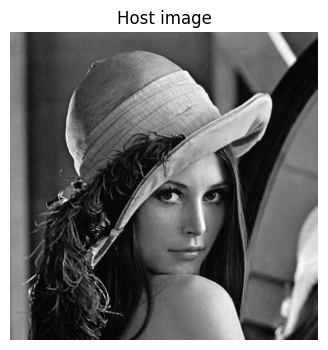

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


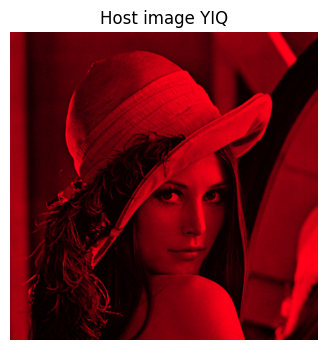

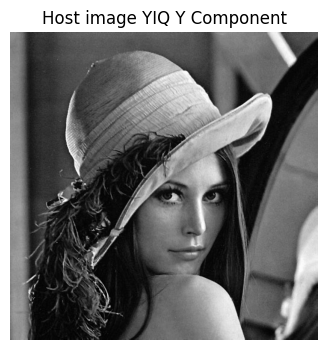

In [4]:
# CONVERT HOST IMAGE FROM RGB TO YIQ

host_image_yiq = rgb_to_yiq(host_image / 255.0)
host_image_yiq_y_comp = host_image_yiq[:, :, 0] # Extract Y component (luminance)

show_image_1(host_image, "Host image")
show_image_1(host_image_yiq, "Host image YIQ")
show_image_1(host_image_yiq_y_comp, "Host image YIQ Y Component")

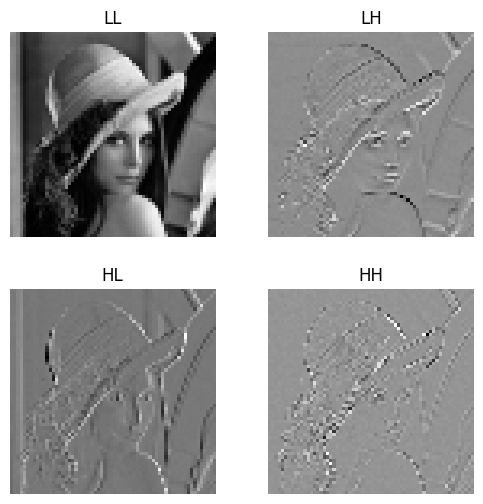

In [5]:
# APPLY 3 LEVEL DWT ON THE Y COMPONENT OBTAINED FROM THE YIQ HOST IMAGE

coeffs = pywt.wavedec2(host_image_yiq[:, :, 0], 'haar', level=3)

sub_bands = coeffs
cA, (cH, cV, cD) = sub_bands = sub_bands[0], sub_bands[1]

res = [cA, cH, cV, cD]
labels = ['LL', 'LH', 'HL', 'HH']
shape_LL = coeffs[0].shape

show_image(res, labels, [2,2])

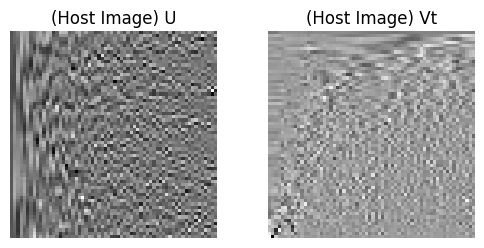

In [6]:
# APPLYING SVD ON THE COEFFICIENTS OBTAINED FROM DWT ABOVE

U, S, Vt = np.linalg.svd(coeffs[0], full_matrices=False)

show_image([U, Vt], [f'(Host Image) U', f'(Host Image) Vt'], [1,2])

SLL = np.zeros(shape_LL)
row = min(shape_LL)
SLL[:row, :row] = np.diag(S)
Sc=SLL

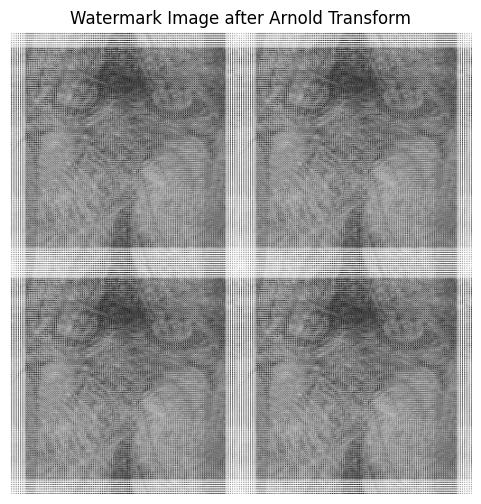

In [7]:
# APPLYING ARNOLD TRANSFORMATION ON THE WATERMARK IMAGE FOR IMAGE SCRAMBLING

def arnold_transform(image, iterations):
    """
    Perform Arnold transformation on the input image for specified number of iterations.
    
    Parameters:
        image (numpy.ndarray): Input image.
        iterations (int): Number of iterations for the Arnold transformation.
        
    Returns:
        numpy.ndarray: Transformed image.
    """
    # Get the dimensions of the image
    height, width, depth = image.shape
    
    # Create an empty array to store the transformed image
    transformed_image = np.zeros_like(image)
    
    # Perform Arnold transformation for the specified number of iterations
    for index in range(iterations):
        # Compute the transformed coordinates using Arnold's cat map
        x, y = np.meshgrid(range(width), range(height))
        x_new = (2 * x + y) % width
        y_new = (x + y) % height
        
        # Map the pixel values to the new coordinates
        transformed_image[y_new, x_new] = image[y, x]
        
        # Update the image for the next iteration
        image = transformed_image.copy()
    
    return transformed_image

# Scrambling Cycle, T = 384, t = 192
arnold_transformed_image = arnold_transform(watermark_image, 192)
show_image([arnold_transformed_image], ["Watermark Image after Arnold Transform"], [1,1])

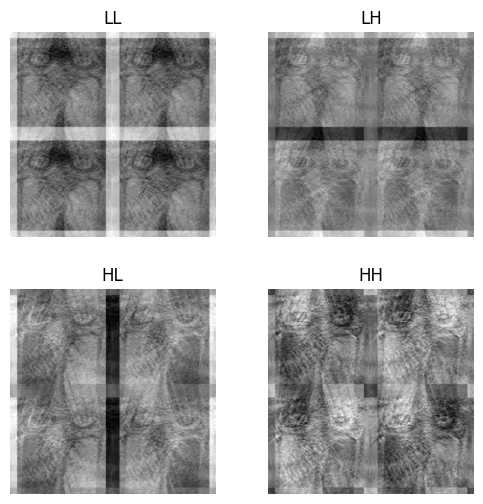

(256, 256)


In [8]:
# APPLYING RGB TO YIQ CONVERSION AND THEN 1 LEVEL DWT ON THE SCRAMBLED WATERMARK IMAGE OBTAINED FROM ARNOLD TRANSFORMATION


arnold_y = rgb_to_yiq(arnold_transformed_image / 255.0)

coeffs_W = pywt.wavedec2(arnold_y[:, :, 0], 'haar', level=1)
cA_W, (cH_W, cV_W, cD_W) = coeffs_W = coeffs_W[0], coeffs_W[1]

res_w = [cA_W, cH_W, cV_W, cD_W]
labels = ['LL', 'LH', 'HL', 'HH']

show_image(res_w, labels, [2,2])
print(cA_W.shape)

In [9]:
# USING DIFFERENTIAL EVOLUTION TO OBTAIN AN OPTIMIZED SCALING FACTOR

def objective_func(scale_factor, original_image, watermark_image):
    watermarked_image = original_image + scale_factor * watermark_image
    
    norm_corr = normalized_correlation(original_image[:,0], watermarked_image[:,0])
    
    return -norm_corr

bounds = [(0, 1)]

result = differential_evolution(objective_func, bounds, args=(host_image[:,:,0], watermark_image[:,:,0]))
scale_factor = result.x[0]

print(f"Optimal scaling factor: {scale_factor}")
print(f"Function value: {result.fun}")

Optimal scaling factor: 0.4506684885188677
Function value: -7.67997022797916


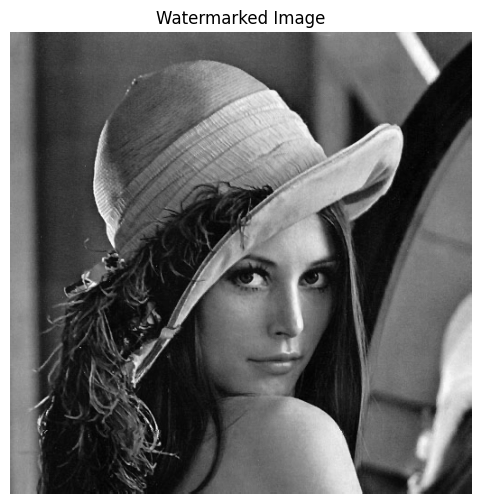

In [10]:
# EMBEDDING WATERMARK USING THE SCALING FACTOR OBTAINED FROM DE

Snew = np.zeros((min(shape_LL),min(shape_LL)))

for py in range(min(shape_LL)):
    for px in range(min(shape_LL)):
        Snew[py][px] = Sc[py][px] + (scale_factor * cA_W[py][px])

Uw, Sw, Vw = np.linalg.svd(Snew)

LLnew = np.zeros((min(SLL.shape),min(SLL.shape)))
LLnew = U.dot(np.diag(Sw)).dot(Vt)
coeffs[0]=LLnew

watermarked_cA = pywt.waverec2(coeffs, 'haar')

show_image([watermarked_cA], ["Watermarked Image"], [1,1])

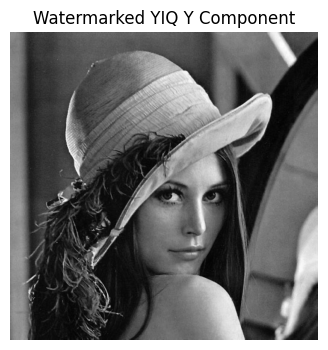

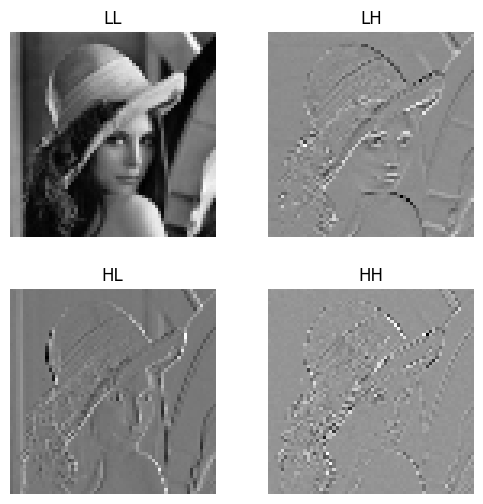

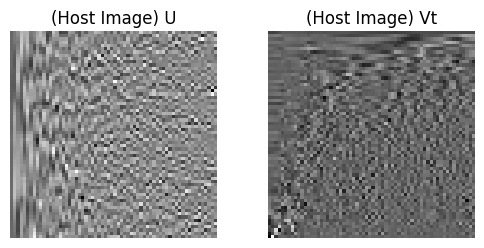

In [11]:
# CONVERT WATERMARKED IMAGE FROM RGB TO YIQ

watermarked_y = watermarked_cA # Extract Y component (luminance)

show_image_1(watermarked_y, "Watermarked YIQ Y Component")

# APPLY 3 LEVEL DWT ON THE Y COMPONENT OBTAINED FROM THE YIQ HOST IMAGE

coeffs_w0 = pywt.wavedec2(watermarked_y, 'haar', level=3)
sub_band_w0 = coeffs_w0
cA_w0, (cH_w0, cV_w0, cD_w0) = sub_band_w0 = sub_band_w0[0], sub_band_w0[1]

res = [cA_w0, cH_w0, cV_w0, cD_w0]
labels = ['LL', 'LH', 'HL', 'HH']

show_image(res, labels, [2,2])

# APPLYING SVD ON THE COEFFICIENTS OBTAINED FROM DWT ABOVE
U, S, Vt = np.linalg.svd(cA_w0, full_matrices=False)

show_image([U, Vt], [f'(Host Image) U', f'(Host Image) Vt'], [1,2])

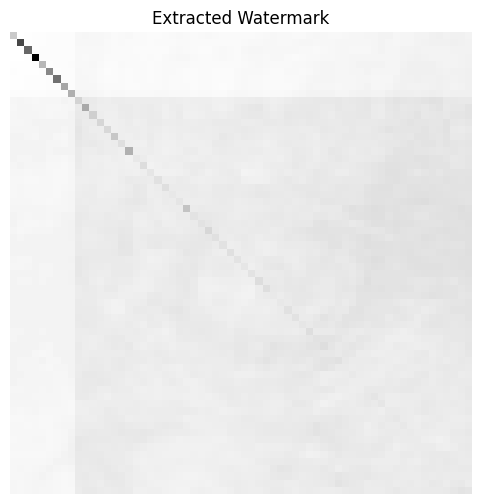

In [12]:
Ucw, Scw, Vcw = np.linalg.svd(coeffs_w0[0])
Uc, Sc, Vc = np.linalg.svd(coeffs[0])

Uw, Sw, Vw = np.linalg.svd(Snew)
LLnew1=Uw.dot(np.diag(Scw)).dot(Vw)


Wdnew = np.zeros((min(shape_LL),min(shape_LL)))

Scdiag = np.zeros(shape_LL)
row = min(shape_LL)
Scdiag[:row, :row] = np.diag(Sc)
Sc=Scdiag


for py in range(0,min(shape_LL)):
    for px in range(0,min(shape_LL)):
        Wdnew[py][px] = (LLnew1[py][px] - Sc[py][px]) / scale_factor
        
show_image([Wdnew], ["Extracted Watermark"], [1,1])

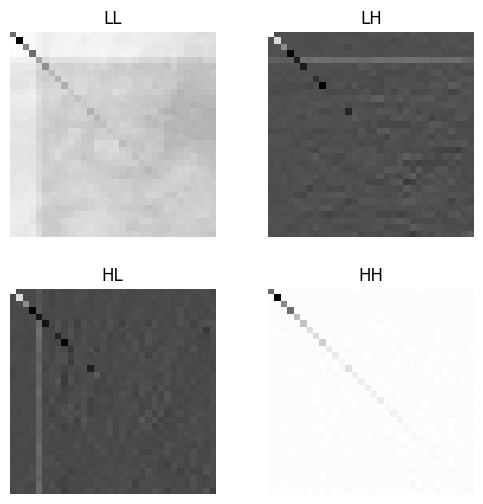

In [13]:
coeffs_W0 = pywt.wavedec2(Wdnew, 'haar', level=1)
wdinew = pywt.waverec2(coeffs_W0, 'haar')
cA_W0, (cH_W0, cV_W0, cD_W0) = coeffs_W0 = coeffs_W0[0], coeffs_W0[1]

res_w0 = [cA_W0, cH_W0, cV_W0, cD_W0]
labels = ['LL', 'LH', 'HL', 'HH']

show_image(res_w0, labels, [2,2])

In [14]:
def psnr(image1, image2):
    """ Compute Peak Signal-to-Noise Ratio """

    image_size = image1.shape[0] * image1.shape[1]
    if np.array_equal(image1, image2):
        return float('inf')
    error = np.sum((image1 - image2) ** 2.0) / image_size
    return 10 * math.log((255.0 ** 2) / error, 10)


x = psnr(cA_w0, coeffs[0])
print(f'PSNR between host image and watermarked image: {x}')


xw = psnr(cA_w0, Wdnew)
print(f'PSNR between watermark and recovered watermark: {xw}')

PSNR between host image and watermarked image: 338.3082228957059
PSNR between watermark and recovered watermark: 38.935119853981774


In [15]:
# def arnold_transform(image, iterations):
#     """
#     Perform Arnold transformation on the input image for specified number of iterations.
    
#     Parameters:
#         image (numpy.ndarray): Input image.
#         iterations (int): Number of iterations for the Arnold transformation.
        
#     Returns:
#         numpy.ndarray: Transformed image.
#     """
#     # Get the dimensions of the image
#     height, width = image.shape
    
#     # Create an empty array to store the transformed image
#     transformed_image = np.zeros_like(image)
    
#     # Perform Arnold transformation for the specified number of iterations
#     for _ in range(iterations):
#         # Compute the transformed coordinates using Arnold's cat map
#         x, y = np.meshgrid(range(width), range(height))
#         x_new = (2 * x + y) % width
#         y_new = (x + y) % height
        
#         # Map the pixel values to the new coordinates
#         transformed_image[y_new, x_new] = image[y, x]
        
#         # Update the image for the next iteration
#         image = transformed_image.copy()
    
#     return transformed_image


# arnold_transformed_w0 = arnold_transform(wdinew, (384-192))
# show_image([arnold_transformed_w0], ["(Extraction) Watermark Image after Arnold Transform"], [1,1])